# Evalutation of Classifiers on full dataset (05/17/2017)

The following are details of my experiments using the Random Forest, Logistic Regression and Multilayer Percpetron learning methods.

In [1]:
import time
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
matplotlib.style.use('ggplot')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from utils import load_data_h5, combine_positive_negative_data, generate_report
from keras_utils import precision, recall
from keras import losses
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping





plt.clf()
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = cm.Spectral
m = cm.ScalarMappable(norm=norm, cmap=cmap)

Using TensorFlow backend.


In [2]:
random_state = 0
t0 = time.clock()
X_p, y_p = load_data_h5("data/ml_pro_features_labels.h5", mode=1)
X_n, y_n = load_data_h5("data/ml_pro_features_labels.h5", mode=0)

print("Data loaded in ", (time.clock() - t0), " seconds.")

X = combine_positive_negative_data(X_n, X_p)
y = combine_positive_negative_data(y_n, y_p)

t1 = time.clock()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
t2 = time.clock()


print ("Train-Test split: ",X_train.shape[0], "(train)","\t",X_test.shape[0], "(test)")
print("Train-Test split completed in ", (t2-t1), " seconds.")

Data loaded in  1.2575750000000006  seconds.
Train-Test split:  159801 (train) 	 39951 (test)
Train-Test split completed in  0.08194999999999997  seconds.


/home/carl/anaconda3/envs/protein_binding/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression trained on full features in  29.220488999999997  seconds.


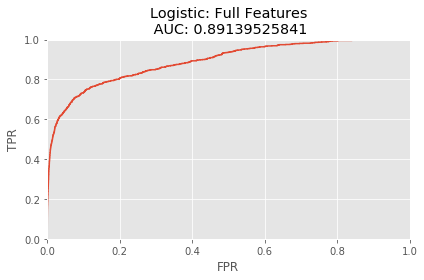

In [3]:
logistic0 = LogisticRegression(random_state=random_state)
t5 = time.clock()
logistic0.fit(X_train, y_train)
print ("Logistic Regression trained on full features in ", (time.clock() - t5), " seconds.")
logistic_preds0 = logistic0.predict(X_test)
generate_report("Logistic: Full Features", logistic0, X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 188)               35532     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 189       
Total params: 35,721.0
Trainable params: 35,721
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 119850 samples, validate on 39951 samples
Epoch 1/100
119850/119850 [==============================] - 1s - loss: 0.1399 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
119850/119850 [==============================] - 0s - loss: 0.1092 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1120 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
119850/119850 [==============================] - 0s - loss: 0.1063 - p

/home/carl/anaconda3/envs/protein_binding/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


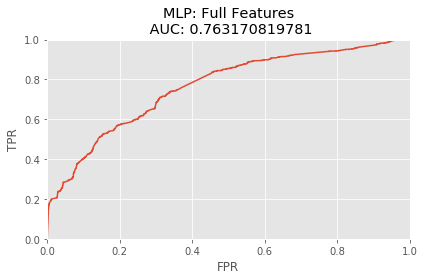

In [4]:
from keras_utils import generate_report_keras
model0 = Sequential()

model0.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='sigmoid'))
model0.add(Dense(1, activation='sigmoid'))


model0.compile(optimizer=Adam(lr=1e-4), loss=losses.binary_crossentropy, metrics=[precision, recall])

print(model0.summary())
t7 = time.clock()
model0.fit(X_train, y_train, batch_size=1000, epochs=100, validation_split=0.25, callbacks=[EarlyStopping()])
print ("MLP trained on full features in ", (time.clock() - t7), " seconds")

generate_report_keras("MLP: Full Features", model0, X_test, y_test)

The multilayer perceptron outperforms the logistic regression in terms of correctly distinguishing true positives from false positives.

/home/carl/anaconda3/envs/protein_binding/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random forest trained on full features in  5.408107999999999  seconds.


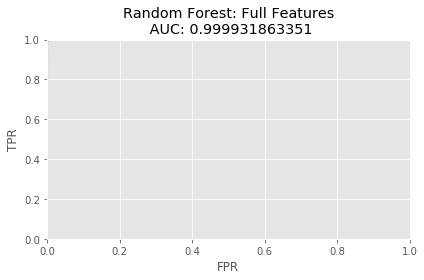

In [5]:
rforest0 = RandomForestClassifier(max_depth=16,random_state=random_state)
t1 = time.clock()
rforest0.fit(X_train, y_train)
print ("Random forest trained on full features in ", (time.clock() - t1), " seconds.")
rforest_preds0 = rforest0.predict(X_test)
generate_report("Random Forest: Full Features", rforest0, X_test, y_test)

The random forest is perhaps unsurprisingly able to improve upon the results of the multilayer perceptron.


# Dimensionality Reduction

In [6]:
X_p, y_p = load_data_h5("data/ml_pro_features_labels.h5", mode=1)
X_n, y_n = load_data_h5("data/ml_pro_features_labels.h5", mode=0)


X = combine_positive_negative_data(X_n, X_p)
y = combine_positive_negative_data(y_n, y_p)

### Linear Dimensionality Reduction (PCA)

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error

X_norm = normalize(X)

pca = PCA(n_components=6)

reduced_x_ = pca.fit_transform(X_norm)

reconstructed_x = pca.inverse_transform(reduced_x_)

error = mean_squared_error(X_norm,reconstructed_x)
print(error)

5.46383838177e-07


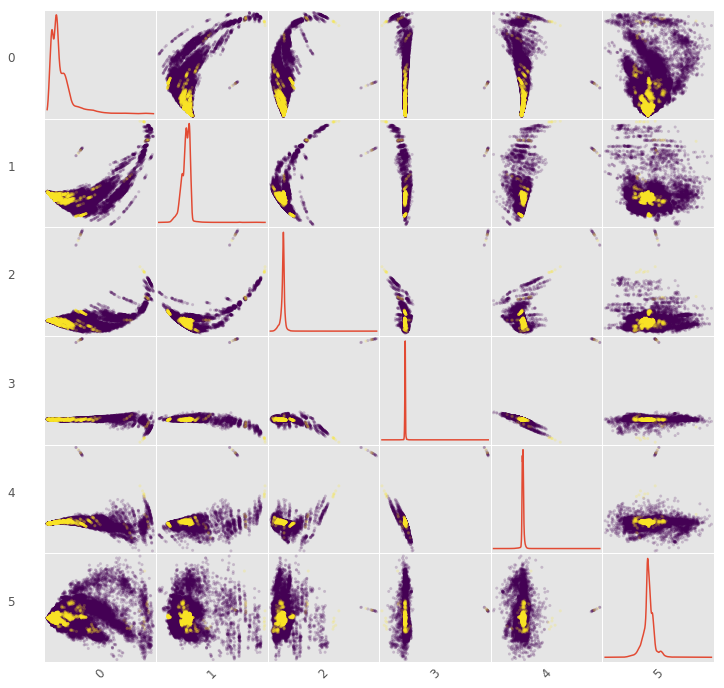

In [8]:
reduced_x_ = pd.DataFrame(reduced_x_)


y_labels = pd.DataFrame(y)

plt.clf()
sm = pd.plotting.scatter_matrix(reduced_x_,alpha=0.2, c = y_labels[0],figsize=(12,12),diagonal='kde')

[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

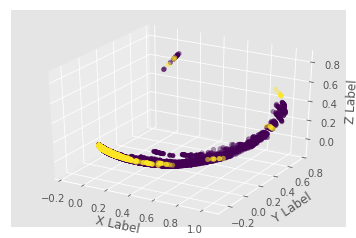

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = reduced_x_.as_matrix()[:,0]
ys = reduced_x_.as_matrix()[:,1]
zs = reduced_x_.as_matrix()[:,2]
ax.scatter(xs, ys, zs, c=y_labels[0])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### Non-linear Dimensionality Reduction
Due to limitations in the scikit-learn dimensionality reduction techniques, an autoencoder deep network is trained to perform the non-linear dimensionality reduction.

### Autoencoder

In [18]:
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from keras import objectives
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.advanced_activations import LeakyReLU, PReLU
from sklearn.preprocessing import normalize
from utils import load_data_h5
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

time_stamp = time.clock()


X_,y_ = load_data_h5("data/ml_pro_features_labels.h5")
X_ = normalize(X_)

num_epochs = 1000
encoding_dim = 3
learning_rate = 1e-3

input_data = Input(shape=(188,))
alpha = 'glorot_uniform'

encoded = Dense(100)(input_data)
encoded = PReLU(alpha_initializer=alpha)(encoded)
encoded = Dense(50)(encoded)
encoded = PReLU(alpha_initializer=alpha)(encoded)
encoded = Dense(25)(encoded)
encoded = PReLU(alpha_initializer=alpha)(encoded)
encoded = Dense(encoding_dim)(encoded)
encoded = PReLU(alpha_initializer=alpha)(encoded)

decoded = Dense(25)(encoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)
decoded = Dense(50)(decoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)
decoded = Dense(100)(decoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)
decoded = Dense(188)(decoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)

autoencoder = Model(input_data, decoded)
print (autoencoder.summary())

encoder = Model(input_data, encoded)
print (encoder.summary())

encoded_input = Input(shape=(encoding_dim,))


decoder = Model(encoded_input,autoencoder.layers[-1](autoencoder.layers[-2](autoencoder.layers[-3](autoencoder.layers[-4](
    autoencoder.layers[-5](autoencoder.layers[-6](autoencoder.layers[-7](autoencoder.layers[-8](encoded_input)))))))))

print (decoder.summary())


autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate),loss=objectives.mean_squared_error)


autoencoder.fit(X_,X_,epochs=num_epochs,batch_size=64,shuffle=True,validation_split=0.2,callbacks=[EarlyStopping(min_delta=1e-7),ModelCheckpoint("best_autoenc_"+str(time_stamp)+"_model.h5")])

enc_red_x = encoder.predict(X_)

plt.clf()
xs = enc_red_x[:,0]
ys = enc_red_x[:,1]
zs = enc_red_x[:,2]
ax.scatter(xs, ys, zs, c=y_labels[0])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
#plt.savefig(str(time_stamp)+"_final_dim_reduction.png")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 188)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               18900     
_________________________________________________________________
p_re_lu_25 (PReLU)           (None, 100)               100       
_________________________________________________________________
dense_28 (Dense)             (None, 50)                5050      
_________________________________________________________________
p_re_lu_26 (PReLU)           (None, 50)                50        
_________________________________________________________________
dense_29 (Dense)             (None, 25)                1275      
_________________________________________________________________
p_re_lu_27 (PReLU)           (None, 25)                25        
__________